In [36]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image

In [37]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [38]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y_ = filename.split('_')[0]
            y_ = label_dict[y_] 
            image_list.append(im)
            y_list.append(y_)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [39]:
dirpath = 'SMAI-PCAdataset/IIIT-CFW/'
X,y_ = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


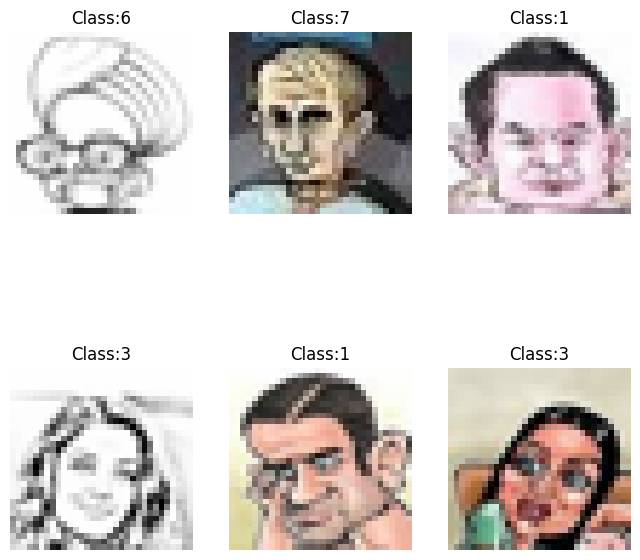

In [40]:
N,H,W = X.shape[0:3]

C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y_.shape[0],6)
display_images(X[ind,...],y_[ind], row=2,col=3)

#### PCA

In [41]:
class PCA:
    def __init__(self,X):
        self.X = X
        self.Z = None
        self.eig_values = None
        self.eig_vectors = None
        
    def fit(self):
        mean = np.mean(self.X,axis=0)
        self.Z = self.X-mean
        # covariance matrix
        cov_matrix = np.cov(self.Z.T)
        # eigen values and eigen vectors
        eig_values, eig_vectors = np.linalg.eig(cov_matrix)
        # sort eigen values and eigen vectors
        eig_values = eig_values.real
        eig_vectors = eig_vectors.real
        idx = eig_values.argsort()[::-1]
        eig_values = eig_values[idx]
        eig_vectors = eig_vectors[:,idx]
        self.eig_values = eig_values
        self.eig_vectors = eig_vectors
    
    def explained_variance(self):
        return np.cumsum(self.eig_values)/np.sum(self.eig_values)
        
    def transform(self,k):
        eig_vectors = self.eig_vectors[:,:k]
        return np.dot(self.Z,eig_vectors)


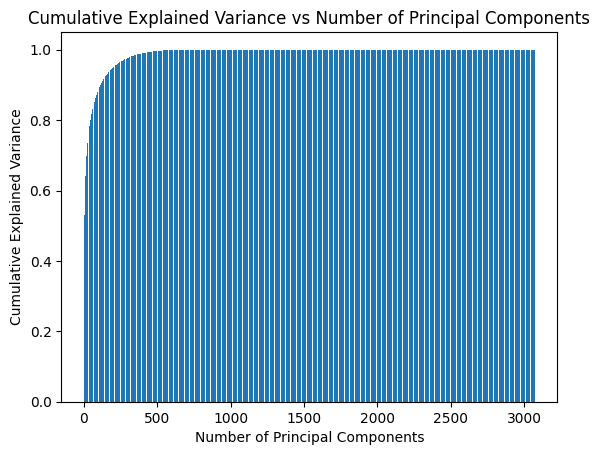

In [50]:
X = X.reshape(N,H*W*C)
p = PCA(X)
p.fit()
t_data = p.transform(H*W*C)
explained_var = p.explained_variance()
plt.bar(np.arange(1, len(explained_var) + 1), explained_var)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Principal Components')
plt.show()

##### PCA on Pictionary dataset

In [43]:
data = np.load("data.npy",allow_pickle=True)
data_resnet = data[:,1]
data_vit = data[:,2]
data_resnet = np.array([data_r[0] for data_r in data_resnet])
data_vit = np.array([data_v[0] for data_v in data_vit])
print(data_resnet.shape)
print(data_vit.shape)

(1500, 1024)
(1500, 512)


In [44]:
p_resnet = PCA(data_resnet)
p_resnet.fit()
p_vit = PCA(data_vit)
p_vit.fit()

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
# RESNET
res = []
data_X = data_resnet
data_Y = np.array(data[:,3])
train_x,test_x,train_y, test_y = train_test_split(data_X, data_Y, test_size=0.2, random_state=42)

for i in range(1,35):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(train_x, train_y)
    score = neigh.score(test_x, test_y)
    res.append([score, i])

s = sorted(res, key=lambda x: x[0], reverse=True)

for i in range(0,20):
    print(s[i][1] , s[i][0])

14 0.19333333333333333
13 0.19
1 0.18666666666666668
11 0.18333333333333332
15 0.18333333333333332
10 0.17666666666666667
12 0.17666666666666667
16 0.17666666666666667
17 0.17
19 0.17
34 0.17
5 0.16666666666666666
8 0.16666666666666666
20 0.16666666666666666
29 0.16666666666666666
33 0.16666666666666666
18 0.16333333333333333
30 0.16333333333333333
32 0.16333333333333333
6 0.16


In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
# VIT
res = []
data_X = data_vit
data_Y = np.array(data[:,3])
train_x,test_x,train_y, test_y = train_test_split(data_X, data_Y, test_size=0.2, random_state=42)

for i in range(1,35):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(train_x, train_y)
    score = neigh.score(test_x, test_y)
    res.append([score, i])

s = sorted(res, key=lambda x: x[0], reverse=True)

for i in range(0,20):
    print(s[i][1] , s[i][0])

1 0.27
19 0.23666666666666666
22 0.23666666666666666
2 0.23333333333333334
17 0.23333333333333334
20 0.23333333333333334
21 0.23333333333333334
29 0.23333333333333334
11 0.23
26 0.23
28 0.23
12 0.22666666666666666
23 0.22666666666666666
25 0.22666666666666666
27 0.22666666666666666
30 0.22666666666666666
16 0.22333333333333333
18 0.22333333333333333
31 0.22333333333333333
32 0.22333333333333333


334 0.19333333333333333
335 0.19333333333333333
336 0.19333333333333333
337 0.19333333333333333
338 0.19333333333333333
339 0.19333333333333333
340 0.19333333333333333
341 0.19333333333333333
342 0.19333333333333333
343 0.19333333333333333
344 0.19333333333333333
345 0.19333333333333333
346 0.19333333333333333
347 0.19333333333333333
348 0.19333333333333333
349 0.19333333333333333
350 0.19333333333333333
351 0.19333333333333333
352 0.19333333333333333
353 0.19333333333333333


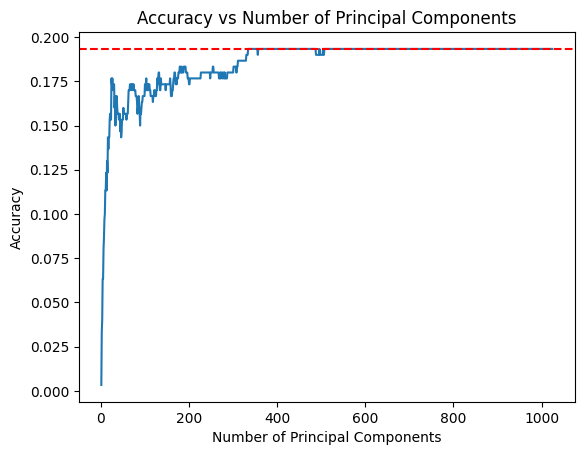

In [47]:
from sklearn.metrics import accuracy_score
# RESNET
res = []
x = []
y=[]
for i in range(1,1025):
    data_X = p_resnet.transform(i)
    data_Y = np.array(data[:,3])
    train_x,test_x,train_y, test_y = train_test_split(data_X, data_Y, test_size=0.2, random_state=42)
    neigh = KNeighborsClassifier(n_neighbors=14)
    neigh.fit(train_x, train_y)
    y_pred = neigh.predict(test_x)
    score = accuracy_score(test_y, y_pred)
    res.append([score,i])
    x.append(i)
    y.append(score)

s = sorted(res, key=lambda x: x[0], reverse=True)
for i in range(0,20):
    print(s[i][1] , s[i][0])
plt.plot(x,y)
plt.axhline(y=0.19333333333333333, color='r', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Principal Components')
plt.show()

154 0.27666666666666667
159 0.27666666666666667
47 0.2733333333333333
53 0.2733333333333333
57 0.2733333333333333
58 0.2733333333333333
112 0.2733333333333333
113 0.2733333333333333
153 0.2733333333333333
158 0.2733333333333333
160 0.2733333333333333
165 0.2733333333333333
168 0.2733333333333333
196 0.2733333333333333
203 0.2733333333333333
245 0.2733333333333333
246 0.2733333333333333
247 0.2733333333333333
248 0.2733333333333333
249 0.2733333333333333


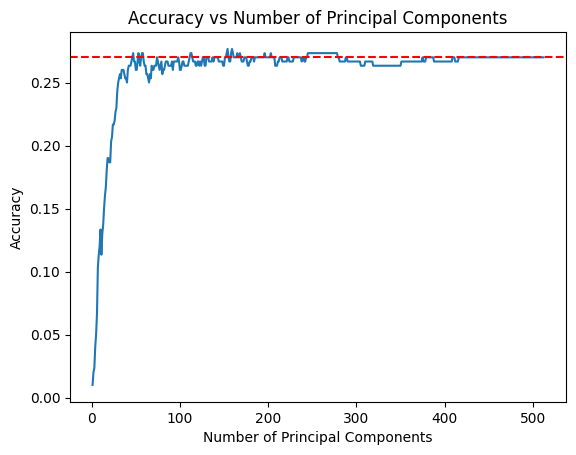

In [48]:
from sklearn.metrics import accuracy_score
# VIT
res = []
x = []
y=[]
for i in range(1,513):
    data_X = p_vit.transform(i)
    data_Y = np.array(data[:,3])
    train_x,test_x,train_y, test_y = train_test_split(data_X, data_Y, test_size=0.2, random_state=42)
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(train_x, train_y)
    y_pred = neigh.predict(test_x)
    score = accuracy_score(test_y, y_pred)
    res.append([score,i])
    x.append(i)
    y.append(score)

s = sorted(res, key=lambda x: x[0], reverse=True)
for i in range(0,20):
    print(s[i][1] , s[i][0])
plt.plot(x,y)
plt.axhline(y=0.27, color='r', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Principal Components')
plt.show()

##### PCA on RESNET 
- Highest accuracy before dimensionality reduction: 0.19333333333333333 
- Highest accuracy after dimensionality reduction: 0.19333333333333333 (no.of.principalcomponents=334) 
##### PCA on VIT 
- Highest accuracy before dimensionality reduction: 0.27 
- Highest accuracy after dimensionality reduction: 0.27666666666666667 (no.of.principalcomponents=154) 
- **Accuracies are almost similar before and after dimensionality rreduction**

##### Accuracy of PCA on CFW dataset

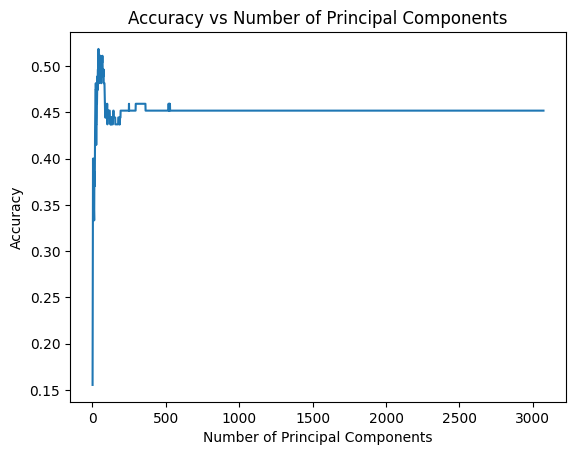

In [51]:
from sklearn.metrics import accuracy_score

x = []
y=[]
for i in range(1,3073):
    data_X = t_data[:,:i]
    train_x,test_x,train_y, test_y = train_test_split(data_X, y_, test_size=0.2, random_state=42)
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(train_x, train_y)
    y_pred = neigh.predict(test_x)
    score = accuracy_score(test_y, y_pred)
    res.append([score,i])
    x.append(i)
    y.append(score)

plt.plot(x,y)
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Principal Components')
plt.show()

##### PROBLEM-1.2

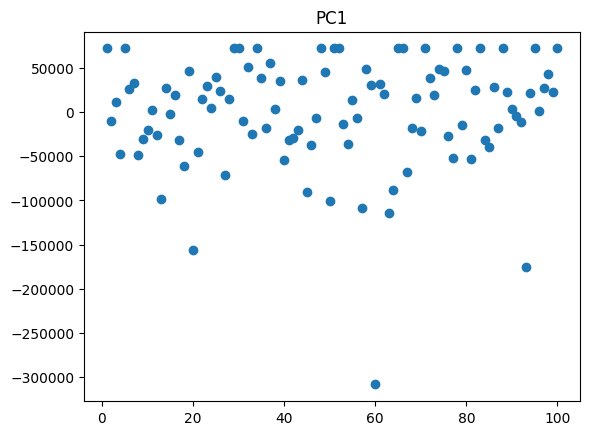

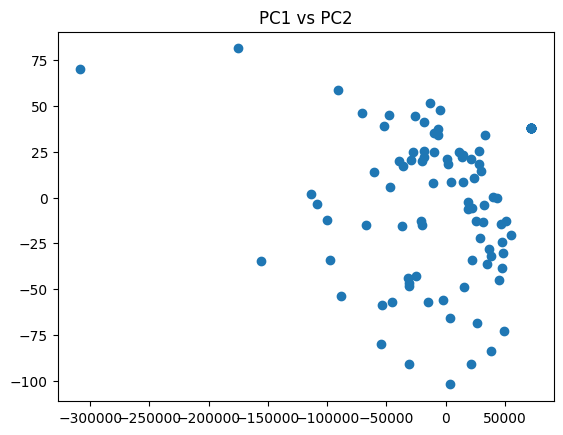

[-2.10955385e+00  1.30225443e+00 -2.17898967e+00 -2.78418513e+00
 -2.10955385e+00 -3.84047264e+00  4.37830674e-01 -7.65611849e-01
 -1.69796616e+00 -3.13448311e-01 -1.23199711e+00  1.40279072e+00
 -4.34106287e+00  1.06447238e-01  5.37862342e+00 -2.63890525e+00
 -3.59307184e+00 -1.17352408e-02  3.61426848e+00 -4.65656024e+00
 -6.59979184e+00 -8.27576082e-01  3.38268865e-01 -1.44173860e+00
  3.51886895e+00  5.93508326e-01  8.06863495e+00 -1.82999909e+00
 -2.10955385e+00 -2.10955385e+00  6.27500671e+00  9.80076527e-02
 -3.32607644e+00 -2.10955385e+00 -5.20050257e-01  7.64701204e+00
  9.20618865e-01 -2.08198546e-02  4.91612610e-01 -6.66339771e+00
 -4.94257058e+00 -1.62457038e+00  1.35442253e+01 -3.17237265e+00
 -1.19593317e+00 -3.80199476e+00 -7.70783082e-01 -2.10955385e+00
 -3.50058206e+00  1.74257290e-01 -2.10955385e+00 -2.10955385e+00
  2.05988866e-01 -2.91576670e+00  3.66095490e+00  1.99448230e+00
 -1.61240703e+00 -4.44284817e+00  1.37519696e+00  2.84351153e+00
  2.19039537e+00 -6.09392

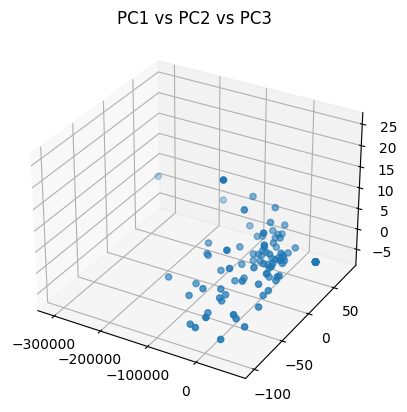

In [ ]:
import pandas as pd
drawer_data = pd.read_csv('smai_assignment_pictionary/drawer_attributes.csv')
# convert to data to array
drawer_data = np.array(drawer_data)
# PCA
drawer_data = drawer_data[:,1:]
dd = PCA(drawer_data)
dd.fit()

# PC1 plot
pc1 = dd.transform(1)
plt.scatter(range(1,pc1.shape[0]+1),pc1)
plt.title('PC1')
plt.show()
# PC1 vs PC2
pc2 = dd.transform(2)
plt.scatter(pc2[:,0],pc2[:,1])
plt.title('PC1 vs PC2')
plt.show()
# PC1 vs PC2 vs PC3
pc3 = dd.transform(3)
print(pc3[:,2])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pc3[:,0],pc3[:,1],pc3[:,2])
plt.title('PC1 vs PC2 vs PC3')
plt.show()

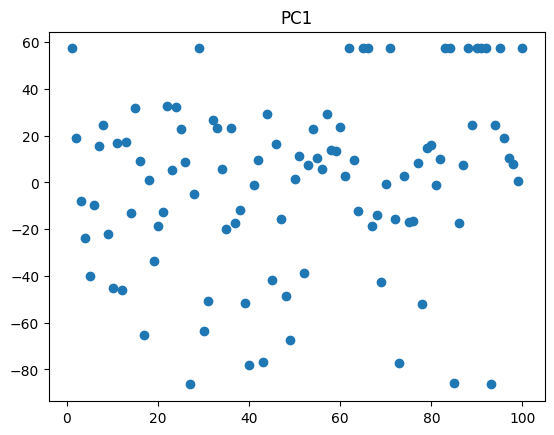

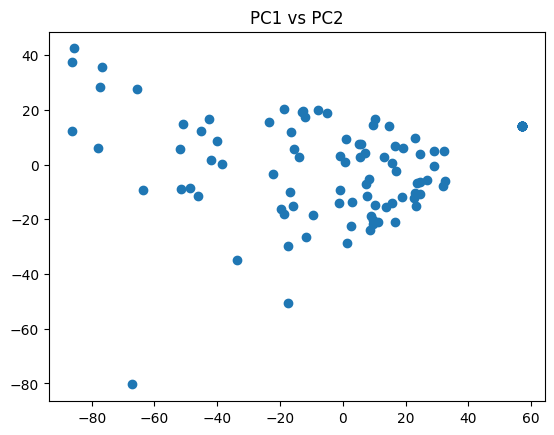

[-9.76849827e-01 -4.20459722e+00  2.60479705e+00  4.04109926e+00
  5.61797230e+00  6.09968521e+00  7.15606430e-01 -5.70438814e+00
  3.43322859e+00  5.62503543e+00  5.17232724e-02 -2.67288930e+01
  3.48464384e+00  2.49496728e+00  2.56047295e+00 -4.81303833e+00
  5.50162784e+00  4.40503930e+00  9.02971636e+00  3.41324940e+00
  4.17915734e+00  8.07974760e-01 -1.83083623e-01  1.46827994e+00
 -2.25950567e+00  7.32108810e-01  8.40818215e+00  2.09848379e+00
 -9.76849827e-01 -7.48722925e+00 -8.89401005e+00  9.01705503e-01
  2.95336406e+00  3.34020227e+00  1.17028375e+00  3.72820126e+00
 -1.56091301e+01  4.20235203e+00 -2.62431194e+01  1.87445747e+00
  4.68818580e+00  2.08719689e+00  5.77776322e+00  2.19595539e+00
 -1.07316426e+01  4.67279056e+00  5.91281222e-01 -6.49451078e+00
  1.50800460e+01  1.67393981e-01  1.50863358e-02 -5.39344869e+00
 -1.29258227e+00 -2.47910036e-01  7.87701677e+00  1.40519820e+00
  2.13463038e+00 -4.42205261e+00 -2.36277378e+00 -2.49270549e+00
 -6.34153050e+00 -9.76849

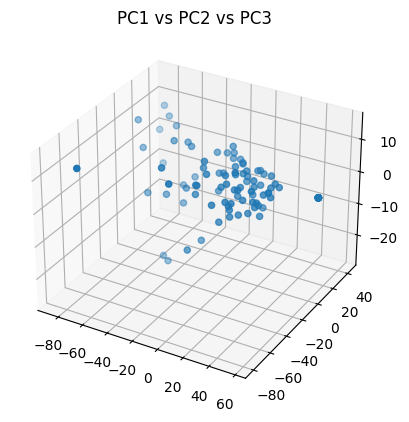

In [ ]:
import pandas as pd
guesser_data = pd.read_csv('smai_assignment_pictionary/guesser_attributes.csv')
# convert to data to array
guesser_data = np.array(guesser_data)
# PCA
guesser_data = guesser_data[:,1:]
gg = PCA(guesser_data)
gg.fit()

# PC1 plot
pc1 = gg.transform(1)
plt.scatter(range(1,pc1.shape[0]+1),pc1)
plt.title('PC1')
plt.show()
# PC1 vs PC2
pc2 = gg.transform(2)
plt.scatter(pc2[:,0],pc2[:,1])
plt.title('PC1 vs PC2')
plt.show()
# PC1 vs PC2 vs PC3
pc3 = gg.transform(3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pc3[:,0],pc3[:,1],pc3[:,2])
plt.title('PC1 vs PC2 vs PC3')
plt.show()

The new axes obtained through PCA are linear combinations of the original axes. These new axes are perpendicular to each other and are ordered based on the amount of variance they capture. The first principal component (PC1) corresponds to the direction with the highest variance and represents the dominant pattern or trend in the data. The second principal component (PC2) represents the direction with the second highest variance and is orthogonal to PC1. PC3 represents the direction with the third highest variance and is orthogonal to both PC1 and PC2. Similarly, higher numbered PCs capture variance in descending order and are orthogonal to each other.